$\textbf{To begin: A simple model for single sodium channels}$:


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def alpha_n (V):
    
    return .01 * (V + 55) / (1 - np.exp(-.1 * (V + 55)))

def beta_n (V):

    return .125 * np.exp(-.0125 * (V + 65))

def alpha_m (V):
    
    return (.1 * (V + 40)) / (1 - np.exp(-.1 * (V + 40)))

def beta_m (V):

    return 4 * np.exp(-.0556 * (V + 65))

def alpha_h (V):
    
    return .07 * np.exp(-.05 * (V + 65))

def beta_h (V):

    return 1 / (1 + np.exp(-.1 * (V + 35)))

In [2]:
#Euler method for solving ODEs:

def euler(f_func, x_0, t_max, dt):
    
    x = x_0
    nsteps = int(t_max / dt)
    xs = np.zeros(nsteps)
    xs[0] = x_0
    i = 1
    t = 0
    
    while i < nsteps:
        
        x = x + f_func(x,t)*dt
        xs[i] = x
        t += dt
        i += 1
    
    return xs

#Solving ODEs for gating dynamics:

dndt = lambda n, t, V: alpha(V) * (1 - n) - beta(V) * n
n = lambda V: euler(lambda n, t: dndt(n,t, V), .3177, 50, .1)

#One objective when cleaning up the code is to make this more dynamical.
#That should take like 5 minutes

#Import Hodgkin-Huxley model code from previous worksheet:

def IK(V, gk, Ek = -77):
    
    return gk * np.power(n(V),4) * (V - Ek)

def INa (V, gNa = 120, ENa = 50):

    return gNA * np.power(m(V),3) * h * (V - ENa)

np.vectorize(IK), np.vectorize(INa)

(<numpy.vectorize at 0x115ebe3d0>, <numpy.vectorize at 0x115ebe610>)

In [4]:
class Potassium_channel:
    
    """
    Potassium channel:
    @attributes:
    numGates: Total number of gates – global attribute
    numOpen: Number of open gates
    state: state of channel, open or closed
    
    This is a very simplified model. Later, for better modelling accuracy,
    it might be necessary to model each channel gate individually
    """
    
    kind = "Potassium"
    
    def __init__(self, numOpen):
        
        numGates = 4
        self.numOpen = numOpen
        self.numGates = numGates
        self.state = "Open" if numOpen == self.numGates else "Closed"
        
    #Getter/Setter methods:
    
    def get_open_channels(self):
        return self.numOpen
        
    def set_open_channels(self, x):
        self.numOpen = x
        
    #Simulate opening/closing of single channel gate:
        
    def open_gate(self):
        
        self.numOpen += 1 if self.numOpen != 4 else 0
        
        if self.numOpen == 4:
            self.state = "Open"
        
    def close_gate(self):
        
        if self.numOpen == 4:
            self.state = "Closed"
        
        self.numOpen -= 1 if self.numOpen != 0 else 0 
        
        
    #Simulate voltage-voltage dependent channel state transitions:
    
    def change_state(self, V, dt = .1):
        
        
        """
        determines the channel's voltage dependent state transitions,
        according to the simple state diagramm 5.12 from Dayan&Abbott.
        @params:
        self: the channel under consideration
        V: the voltage across the membrane
        """
        
        k = self.get_open_channels()
        kMinus = 4 - k
        randNum = np.random.uniform(0,1)
        
        if randNum > 1 - kMinus * alpha(V) * dt:
            
            self.open_gate()
            
        if randNum < k * beta(V) * dt:
            
            self.close_gate()
        
        return self


In [14]:
class Sodium_channel:
    
    """
    sodium channel:
    @attributes:
    numGates: total number of gates - global attribute inherited from 
    parent class
    mGates: The number of open $m$ gates: 1,2 or 3
    hGate: The state of the $h$ gate
    state: The overall state of the channel: "open", "closed",
    "inctivated"
    
    """
    
    kind = "Sodium"
    
    def __init__(self, mGateState, hGateState):
        
        #Catch invalid inputs:
        
        assert(mGateState in np.arange(4)), "Error: mGate value invalid"
        assert(hGateState in np.arange(2)), "Error: hGate value invalid"
        
        #Create sodium channel object:
        
        numGates = 4
        self.numGates = numGates
        self.mGateState = mGateState
        self.hGateState = hGateState
        self.Gates = (self.mGateState, self.hGateState)
    
        self.state = "Inactivated" if self.hGateState == 0 \
                    else "Open" if self.mGateState == 3 \
                    else "Closed"
        
    #Getter/Setter methods:
        
    def get_mGateState(self):
        return self.mGateState 
    
    def get_hGateState(self):
        return self.hGateState
    
    def get_state(self):
        return self.state
    
    def set_mGateState(self,x):
        
        assert(x in np.arange(4)), "Error: Invalid value"
        self.mGateState = x
    
    def set_hGateState(self,x):
        
        assert(x in np.arange(2)), "Error: Invalid value"
        self.hGateState = x 
        
    def open_gate(self):
        
        self.mGateState += 1 if self.mGateState != 3 else 0
        
        if self.mGateState * self.hGateState == 3:

            self.state = "Open"
        
    def close_gate(self):
        
        if self.mGateState * self.hGateState == 3:
            self.state = "Closed"
        
        self.mGateState -= 1 if self.mGateState != 0 else 0 
        
    def activate_gate(self):
        
        if self.hGateState == 0:
            self.state = "Open" if self.mGateState == 3 \
                                else "Closed"
        
        self.hGateState += 1 if self.hGateState != 1 else 0
        
    def inactivate_gate(self):
        
        if self.hGateState != 0:
            self.state = "Inactivated"
        
        self.hGateState -= 1 if self.hGateState != 0 else 0
        self.mGateState = 3
    
    
     #Simulate voltage-voltage dependent channel state transitions:
    
    def change_state(self, V, dt = .1):
        
        #This is only marginally different from the earlier function for
        #the potassium channel. Therefore, a clean piece of code would 
        #have this as a function to a parent class Channel. Then, this
        #sequence of lines of code would appear only once.
        
        #Keep in mind that for the sodium channel, we can only reach the
        #inactivated state if at least one of the mgates is open.
        
        """
        determines the channel's voltage dependent and 
        voltage-independent state transitions,
        according to the simple state diagramm 5.13 from Dayan&Abbott.
        @params:
        self: the channel under consideration
        V: the voltage across the membrane
        """
        
        m = self.get_mGateState()
        h = self.get_hGateState()
        mMinus = 3 - m
        hMinus = 0 if hMinus == 1 else 0
        m_randNum, h_randNum = np.random.uniform(0,1),\
                               np.random.uniform(0,1)
    
        
        if randNum > 1 - mMinus * alpha_m(V) * dt:
            
            self.open_gate()
            
        if randNum > 1 - hMinus * alpha_m(V) * dt:
        
            self .inactivate_gate()
            
        if randNum < m * beta_m(V) * dt:
            
            self.close_gate()
        
        return self
    



In [ ]:
class Gate:
    
    def __init__(self, state, )

In [15]:
def simulate_channel (V):
    
    
    """
    Simulates a channel over a given period
    @params:
    V: an array detailing timecourse of the voltage over
    the modeled period
    
    """
    
    gates = np.array([None for i in range (V.shape[0])])
    i = 0 
    
    #Initialize channel with random gate configuration:
    
    chan = Potassium_channel(np.random.choice([0,1,2,3,4]))
    
    while i < len(gates):
        
        chan = chan.change_state(V[i])
        gates[i] = chan.numOpen
        
        i += 1 
        
    gates = np.where(gates >= 4, 1, 0)
        
    return gates


def simulate_multiple_channels (numChans, V):
    
    """
    Simulates multiple channels over the timecourse of an ecxperiment
    @params:
    V: as before 
    numChans: the number of modeled channels
    
    """
 
    acc = np.zeros(V.shape[0])
    
    for i in range(numChans):
    
        acc = acc + simulate_channel(V)
    
    return acc

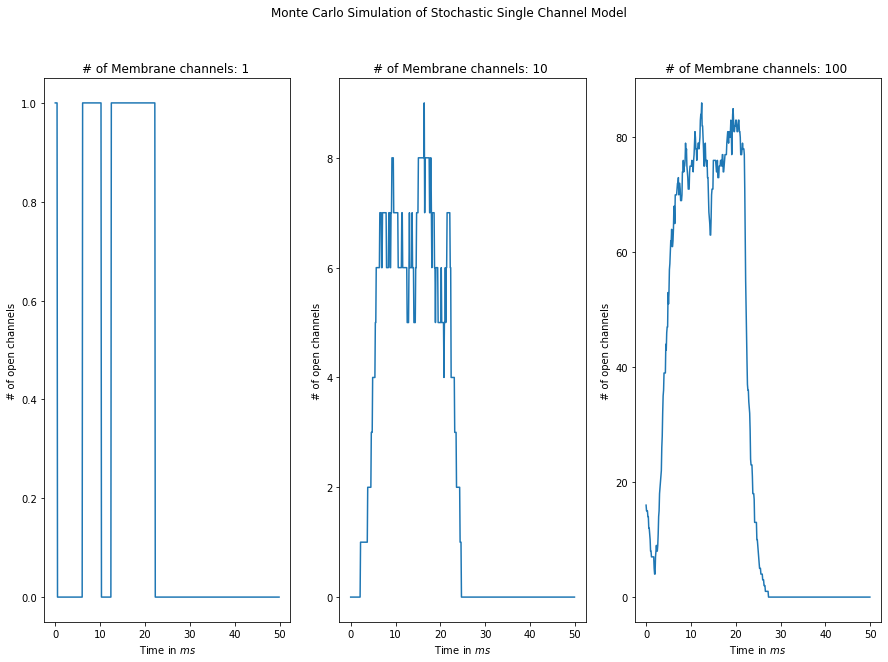

In [13]:
#Space for testing functions:.

def plot_test_result():
    
    interval = np.arange(0, 50, .1)

    clampTime = 20
    unclampTime = 220

    volt_arr = np.ones(500) * 10
    volt_arr[:clampTime +1], volt_arr[unclampTime:] = -100, -100
    
    fig, axs = plt.subplots(1,3, sharex = True, figsize = (15, 10))
    
    plt.suptitle('Monte Carlo Simulation of Stochastic Single Channel Model')
    
    for i in range(axs.shape[0]):
        
        axs[i].plot(interval,\
                    simulate_multiple_channels(np.power(10,i), volt_arr))
        axs[i].set_xlabel('Time in $ms$')
        axs[i].set_ylabel('# of open channels')
        axs[i].set_title('# of Membrane channels: {} '\
                         .format(np.power(10,i)))
    

plot_test_result()

$\textbf{Preliminary result}$: So that result appears qualitatively right. As we increase the number of channels, the shape of our curve (and hence, the shape of our current) eventually smoothens. According to the law of large numbers the empirical average of the number of open channels will converge against its expected value as the number of channels modelled $\rightarrow \infty$. It remains to check whether that expected value conforms with that predicted by the HH-model.

In [17]:
#For the moment, we shall use chCondu = 1, since this is a lower bound 
#accrding to C. Koch 1999. The theoretical maximum conductance across
#the entire membrane then simple eqauls #modelled channels

def potassium_current (V, numChans, chCondu = 36, Ek = -77):
    
    """
    Calculates potassium current for simulated potassium channels
    Also returns the HH model prediction for those parameters
    @params:
    V: voltage in mV
    chCondu: the single channel conductance
    numChans: how many channels are simulated?
    """
    
    dayan_abott = simulate_multiple_channels(numChans, V) * chCondu * (V - Ek)
    hodgkin_huxley = IK(V, gk = chCondu * numChans)    
        
    return dayan_abott, hodgkin_huxley

plt.plot(potassium_current(np.repeat(-50,500), 10))

def potassium_clamp(clampTime, unclampTime, totalTime, Vc, Vh, numChans):
    
    """
    This is the experiment from 5.12 that has to be replicated:
    The voltage is held at -100mV initially. Then it is clamped
    to 10mV for 20 seconds, before it is again unclamped. We'll
    let the time at which the clamp starts be 2 seconds. 
    Also return the HH model prediction for those parameters.
    @params:
    clampTime: the time we clamp the voltage to Vc
    unclampTime: the time the voltage is unclamped and goes back to Vh
    totalTime: the duration of the full experiment
    Vc: the clamping voltage
    Vh: the holding voltage
    numChans: the number of channels modelled
    
    """
    
    volt_arr = np.ones(totalTime) * Vc
    volt_arr[:clampTime +1], volt_arr[unclampTime:] = Vh, Vh
    
    
    return potassium_current(volt_arr, numChans)


plt.figure()
plt.plot(potassium_clamp(20,220,500,10,-100,100))
plt.plot(IK())

ValueError: setting an array element with a sequence.

NameError: name 'potassium_clamp' is not defined

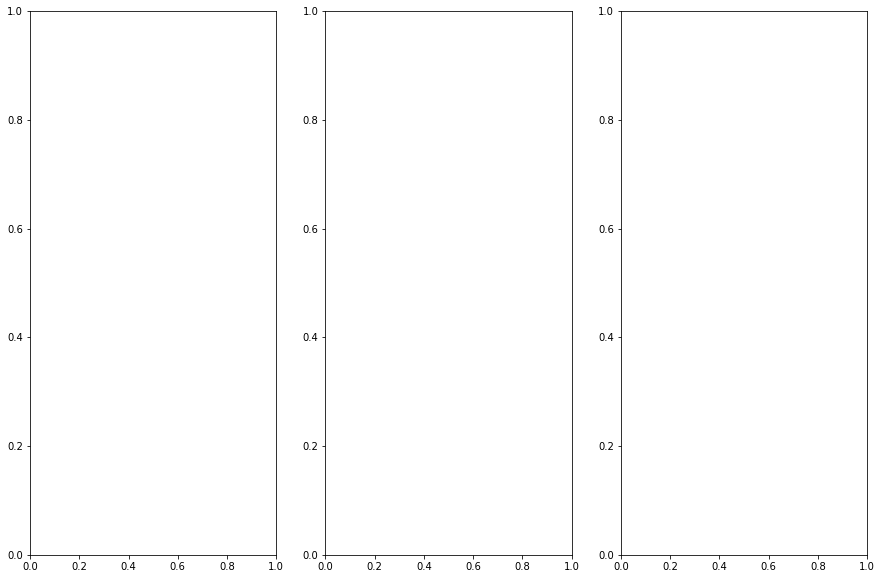

In [16]:
#Plotting final results for the potassium channel:

def plot_final_results():
    
    interval = np.arange(0,50, .1)
    
    numChannels = np.array([1,10,100])
    
    fig, axs = plt.subplots(1,3, sharex = True, figsize = (15,10))
    
    for nI, numCh in np.ndenumerate(numChannels):
        
        res = potassium_clamp(20,220,500, 10, -10, numCh)
        
        axs[nI].plot(interval, res[0])
        axs[nI].plot(interval, res[1])
        
        
plot_final_results()

$\textbf{Continued efforts: the sodium channel}$

In [ ]:
# To model the sodium channel, we cannot operate with the channel class
# any longer since that. I should also make the earlier class a potassium
# channel class and introduce a very sparse parten class Ion channel, with
# possibly only a single attribute: numChannels.
# Actually, that's what I'll do now.

In [ ]:
np.repeat(3,2).shape[0]
